멀테레이블 분류 - 클래스별 sigmoid 함수 사용

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import random
import os

import torch
from transformers import AutoTokenizer, AutoModel


def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 42

# 현재 device 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
DATA_PATH = '/content/drive/MyDrive/2조_누구냐, 넌!/04. 기타자료/Naver_shopping_크롤링/Modeling/한수길/data/'

In [5]:
DATA_PATH_model = '/content/drive/MyDrive/2조_누구냐, 넌!/04. 기타자료/Naver_shopping_크롤링/Modeling/한수길/data/'

In [6]:
df = pd.read_csv(f"{DATA_PATH}train_topic.csv")
df

,content,score,date,brand,가격,세정력/거품,향기,트러블/진정,배송/서비스/고객대응,탈모 효과 및 쿨링감,머릿결*
0,시원하고 좋은데 뾰루지 많이나고 따갑네요,1,23.09.07.,라보에이치,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,저랑은 안맞네요 계속 쓰다보니 두피 너무 가렵고 비듬각질이 생기네요,1,23.02.18.,라보에이치,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,효과는없고 계속많이빠져요,1,22.07.27.,라보에이치,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,"제품이 어떤지는 잘 모르겠고요, 아모레퍼시픽이 소비자 생각 안 하는 회사인 건 확실...",1,22.04.05.,라보에이치,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,ㅋㅋ최악이에요 진짜.. 3월1일에 주문했는데 3월 30일인 오늘 도착했네요 그냥 취...,1,22.03.30.,라보에이치,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4731,머리빠짐이 덜한것 같은데 일단 더 사용해 볼게요~ 무엇보다 샴푸를 쓰고 나면 타샴푸...,5,21.11.25.,반코르,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4732,확실히 기름기랑 두피여드름이 줄었어요,5,22.01.12.,반코르,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4733,1. 머리 덜 간지러움 2. 각질 비듬 줄어듬 3. 머리카락이 두꺼워지는게 느껴짐 ...,5,21.12.12.,반코르,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4734,지성두피라서 오후만 되면 앞머리 떡지던 사람으로서 이정도로 만족스러운 샴푸는 처음입...,5,21.12.01.,반코르,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4736 entries, 0 to 4735
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   content      4736 non-null   object 
 1   score        4736 non-null   int64  
 2   date         4736 non-null   object 
 3   brand        4736 non-null   object 
 4   가격           4736 non-null   float64
 5   세정력/거품       4736 non-null   float64
 6   향기           4736 non-null   float64
 7   트러블/진정       4736 non-null   float64
 8   배송/서비스/고객대응  4736 non-null   float64
 9   탈모 효과 및 쿨링감  4736 non-null   float64
 10  머릿결*         4736 non-null   float64
dtypes: float64(7), int64(1), object(3)
memory usage: 407.1+ KB


# target값 2차원 배열로 만들기

In [8]:
target = df.iloc[:,4:].to_numpy().reshape(-1,7)
target

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]])

# 사전학습 모델 kcelectra

In [9]:
model_name = "beomi/KcELECTRA-base-v2022"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [10]:
train_token = tokenizer(df['content'].tolist(), padding="max_length", truncation=True)

In [11]:
input_ids = np.array(train_token['input_ids'])
attention_mask = np.array(train_token['attention_mask'])
token_type_ids = np.array(train_token['token_type_ids'])

input_ids.shape, attention_mask.shape, token_type_ids.shape

((4736, 512), (4736, 512), (4736, 512))

In [12]:
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_mask, token_type_ids, y=None):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        self.y = y

    def __len__(self):
        return self.input_ids.shape[0]

    def __getitem__(self, idx):
        item = {}
        item['input_ids'] = torch.tensor(self.input_ids[idx])
        item['attention_mask'] = torch.tensor(self.attention_mask[idx])
        item['token_type_ids'] = torch.tensor(self.token_type_ids[idx])
        if self.y is not None:
            item['y'] = torch.Tensor(self.y[idx])

        return item

In [13]:
class Net(torch.nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.output_layer = torch.nn.Linear( self.model.config.hidden_size , 7)

    def forward(self, input_ids, attention_mask, token_type_ids):
        x = self.model(input_ids, attention_mask, token_type_ids)
        x = self.output_layer(x[0][:,0])
        return x

In [14]:
def train_loop(dataloader, model, bce_loss_fn, optimizer, device):
    epoch_loss = 0
    model.train() # 모델 객체를 학습모드로 전환
    for batch in tqdm(dataloader):
        pred = model(batch["input_ids"].to(device), batch['attention_mask'].to(device), batch['token_type_ids'].to(device))

        # multi-label Classification loss
        bce_loss = bce_loss_fn(pred , batch["y"].to(device))

        optimizer.zero_grad()
        bce_loss.backward()
        optimizer.step()

        epoch_loss += bce_loss.item()

    epoch_loss /= len(dataloader)

    return epoch_loss

In [15]:
@torch.no_grad()
def test_loop(dataloader,model,bce_loss_fn, device):
    model.eval() # 평가 모드
    sig = torch.nn.Sigmoid()
    pred_list = []

    epoch_loss = 0
    for batch in tqdm(dataloader):
        pred = model(batch["input_ids"].to(device), batch['attention_mask'].to(device), batch['token_type_ids'].to(device))

        # 검증 평가할 경우
        if batch.get("y") is not None:
            bce_loss = bce_loss_fn(pred, batch["y"].to(device))

            epoch_loss += bce_loss.item()

        # 예측값 만들기
        pred = sig(pred).to("cpu").numpy()

        pred_list.append(pred)

    pred = np.concatenate(pred_list)
    epoch_loss /= len(dataloader)
    return epoch_loss, pred

In [16]:
!pip install iterative-stratification

In [17]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score

batch_size = 4
bce_loss_fn = torch.nn.BCEWithLogitsLoss()
epochs = 100
n_splits = 5
cv = MultilabelStratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True)

In [18]:
is_holdout = False
reset_seeds(SEED)
best_score_list = []
best_recall_score_list = []
best_precision_score_list = []

for i, (tri, vai) in enumerate(cv.split(input_ids, target)):
    model = Net(model_name).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    # 학습용
    train_dt = ReviewDataset(input_ids[tri], attention_mask[tri], token_type_ids[tri], target[tri])
    train_dl = torch.utils.data.DataLoader(train_dt, batch_size=batch_size, shuffle=True)

    # 검증용
    valid_dt = ReviewDataset(input_ids[vai], attention_mask[vai], token_type_ids[vai], target[vai])
    valid_dl = torch.utils.data.DataLoader(valid_dt, batch_size=batch_size, shuffle=False)

    best_score = 0
    best_recall_score = 0
    best_precision_score = 0


    patience = 0
    for epoch in tqdm(range(epochs)):
        train_loss = train_loop(train_dl, model, bce_loss_fn, optimizer, device)
        valid_loss, pred= test_loop(valid_dl, model, bce_loss_fn, device)

        # multi-label Classification
        pred = (pred > 0.5).astype(int)
        f1 = f1_score(target[vai], pred, average='macro')
        recall = recall_score(target[vai], pred, average='macro')
        precision = precision_score(target[vai], pred, average='macro')
        patience += 1

        if best_score < f1:
            patience = 0
            best_score = f1
            best_recall_score = recall
            best_precision_score = precision
            torch.save(model.state_dict(), f"{DATA_PATH_model}model_mlc_{i}.pth")

        print("f1_score_1:", f1)
        print("recall:", recall)
        print("precision:", precision)
        print("train_loss:", train_loss)
        print("valid_loss:", valid_loss)
        if patience == 3:
            break

    print(f"{i} 번째 폴드 best f1_score_1: {best_score}")
    print(f"{i} 번째 폴드 best recall_score: {best_recall_score}")
    print(f"{i} 번째 폴드 best precision_score: {best_precision_score}")
    best_score_list.append(best_score)
    best_recall_score_list.append(best_recall_score)
    best_precision_score_list.append(best_precision_score)
    if is_holdout:
        break

print(np.mean(best_score_list))
print(np.mean(best_recall_score_list))
print(np.mean(best_precision_score_list))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.7760091710292523
recall: 0.7603678620067748
precision: 0.8685026225073307
train_loss: 0.3452102576189906
valid_loss: 0.22785078510956422


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8447168491186626
recall: 0.8364748526591305
precision: 0.8656335957043738
train_loss: 0.18701218849417403
valid_loss: 0.17526587726006024


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8680666516460173
recall: 0.8733768134787115
precision: 0.8787724674534351
train_loss: 0.13910023055436238
valid_loss: 0.16171171419511113


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8819372594673343
recall: 0.910589614477818
precision: 0.8555368259321919
train_loss: 0.1059547163730778
valid_loss: 0.15812793113920004


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8827909102738263
recall: 0.9118734356403818
precision: 0.8566653998053092
train_loss: 0.08187988719545336
valid_loss: 0.16701942484212828


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.874273843856575
recall: 0.8886124939824188
precision: 0.8654624562434338
train_loss: 0.0647622721352249
valid_loss: 0.16190543520472597


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8822395023163593
recall: 0.9009409068894001
precision: 0.8654983710752507
train_loss: 0.04828614558050024
valid_loss: 0.17099977762905982


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8806679429455225
recall: 0.9000565760233483
precision: 0.8630589911350076
train_loss: 0.03754310209190135
valid_loss: 0.17931480528708185
0 번째 폴드 best f1_score_1: 0.8827909102738263
0 번째 폴드 best recall_score: 0.9118734356403818
0 번째 폴드 best precision_score: 0.8566653998053092


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.7690793719956966
recall: 0.7304463650578695
precision: 0.8671636109709444
train_loss: 0.3391626403128673
valid_loss: 0.2072107645718357


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8640039732537428
recall: 0.8678567671895434
precision: 0.8716688282094903
train_loss: 0.1830405417892626
valid_loss: 0.15968058885464184


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8813902260634655
recall: 0.8967162704139044
precision: 0.8706594604353624
train_loss: 0.13832161502464663
valid_loss: 0.14698886017036086


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8795818716353933
recall: 0.8936137466668672
precision: 0.869276356871439
train_loss: 0.10675964943027194
valid_loss: 0.14525709897751296


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8878216758776859
recall: 0.910252414336927
precision: 0.8679881273993721
train_loss: 0.08351497128723731
valid_loss: 0.14990763056960413


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8735424696893309
recall: 0.882291383692962
precision: 0.8701937628692978
train_loss: 0.06373072491235686
valid_loss: 0.15303164849820142


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8974123331813262
recall: 0.9315404854095322
precision: 0.8666189786529758
train_loss: 0.04940584632135802
valid_loss: 0.15610231908297614


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8839089931839615
recall: 0.8961819512113357
precision: 0.8765547659463518
train_loss: 0.03835615910440369
valid_loss: 0.1561813849999023


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8921910565903549
recall: 0.910761980345053
precision: 0.8749804582191132
train_loss: 0.031204602454164173
valid_loss: 0.15495456681480702


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8929770195076573
recall: 0.9162812421759202
precision: 0.8721640908101428
train_loss: 0.025933113007586182
valid_loss: 0.159785882681844
1 번째 폴드 best f1_score_1: 0.8974123331813262
1 번째 폴드 best recall_score: 0.9315404854095322
1 번째 폴드 best precision_score: 0.8666189786529758


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/947 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8080309059268298
recall: 0.7920906196613794
precision: 0.8601678273620527
train_loss: 0.3440204799773197
valid_loss: 0.20768521650682523


  0%|          | 0/947 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8608774674056072
recall: 0.8608653906361374
precision: 0.8718652624918297
train_loss: 0.18950667424243506
valid_loss: 0.16334932767452068


  0%|          | 0/947 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8686584183219059
recall: 0.8585497961560206
precision: 0.8906497196208883
train_loss: 0.14023154839448465
valid_loss: 0.15161896355544466


  0%|          | 0/947 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8861285373997926
recall: 0.9080720810527724
precision: 0.8715557669647952
train_loss: 0.11132018345603847
valid_loss: 0.1488802808843836


  0%|          | 0/947 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8848743830294922
recall: 0.8905477591555008
precision: 0.8878352003497285
train_loss: 0.08476756803825136
valid_loss: 0.14863985044418004


  0%|          | 0/947 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.886598334871245
recall: 0.8972694913247191
precision: 0.878803655288863
train_loss: 0.06671027771916158
valid_loss: 0.14929867645466252


  0%|          | 0/947 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8831934390983353
recall: 0.9109962046232594
precision: 0.8578583982984392
train_loss: 0.05036633672171057
valid_loss: 0.16384298900998973


  0%|          | 0/947 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8827712800554233
recall: 0.9037798221496401
precision: 0.8656256332861839
train_loss: 0.03888249991967126
valid_loss: 0.16661760693156644


  0%|          | 0/947 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8896050762711765
recall: 0.9141476092228761
precision: 0.8673305549707059
train_loss: 0.0325147905814783
valid_loss: 0.16218901212417564


  0%|          | 0/947 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8874423288311627
recall: 0.9048767524571302
precision: 0.8747427838439544
train_loss: 0.024049407154431816
valid_loss: 0.17466276121141097


  0%|          | 0/947 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.884577440515894
recall: 0.9135094601981032
precision: 0.8588627541911654
train_loss: 0.018359495338432123
valid_loss: 0.1823373418694307


  0%|          | 0/947 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8886063155634171
recall: 0.8913565775517306
precision: 0.8919862255299872
train_loss: 0.016707189260896416
valid_loss: 0.18227865017423964
2 번째 폴드 best f1_score_1: 0.8896050762711765
2 번째 폴드 best recall_score: 0.9141476092228761
2 번째 폴드 best precision_score: 0.8673305549707059


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.7945301237643916
recall: 0.7620911251858021
precision: 0.8505313642893194
train_loss: 0.3521398666633081
valid_loss: 0.2187948035477083


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.846181922711264
recall: 0.8233608146706152
precision: 0.8838273849427204
train_loss: 0.19323472678268383
valid_loss: 0.17083300216288505


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8657567402432053
recall: 0.8675359067703953
precision: 0.8749038383413904
train_loss: 0.14209920824564334
valid_loss: 0.16369261317552394


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8885861052291811
recall: 0.8960005891941607
precision: 0.8854306545096436
train_loss: 0.11051740038369778
valid_loss: 0.1468729755845125


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8853757240004707
recall: 0.9046549305129776
precision: 0.8684582677157294
train_loss: 0.08613252310663902
valid_loss: 0.1560150951280687


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8727796292054248
recall: 0.8803786809638717
precision: 0.8684523291344248
train_loss: 0.06586413232428867
valid_loss: 0.15748892129567857


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8895384900843452
recall: 0.8992899508020805
precision: 0.8849938042736357
train_loss: 0.0509490070536434
valid_loss: 0.1495596387144571


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8790419801420171
recall: 0.8811030906583629
precision: 0.878638188345053
train_loss: 0.039763372291747937
valid_loss: 0.16037615427338686


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8844035150260703
recall: 0.8878254528494883
precision: 0.8878455539765149
train_loss: 0.03129879893579831
valid_loss: 0.16127657433303724


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8838002016421047
recall: 0.8903148777434708
precision: 0.8809244387286643
train_loss: 0.022933731475974658
valid_loss: 0.17204791918408738
3 번째 폴드 best f1_score_1: 0.8895384900843452
3 번째 폴드 best recall_score: 0.8992899508020805
3 번째 폴드 best precision_score: 0.8849938042736357


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.7826114948289439
recall: 0.7380536949593626
precision: 0.8890424448541703
train_loss: 0.35071040329205083
valid_loss: 0.21363941297123704


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8693124001463681
recall: 0.8760144636689866
precision: 0.8675108496619541
train_loss: 0.19584120373842837
valid_loss: 0.16122439340197084


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8794218513021398
recall: 0.8996080269542744
precision: 0.8667191215836763
train_loss: 0.14662628632651853
valid_loss: 0.15508037087220683


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8907534732101462
recall: 0.9028776644302842
precision: 0.882387640739149
train_loss: 0.11567084853564888
valid_loss: 0.1471738963297525


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8833940401834509
recall: 0.895673614477185
precision: 0.8786896314086275
train_loss: 0.08888789580325411
valid_loss: 0.14859718402635447


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.896581508062623
recall: 0.9184977635954699
precision: 0.8764729270391374
train_loss: 0.07047733113578351
valid_loss: 0.13919014079724182


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8904748130817799
recall: 0.9118414254855703
precision: 0.8735420547026044
train_loss: 0.05226152139039954
valid_loss: 0.15524775137582533


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.891026329605333
recall: 0.8962956411030739
precision: 0.8907654931384503
train_loss: 0.03971955414079444
valid_loss: 0.1554035046196814


  0%|          | 0/948 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

f1_score_1: 0.8939142372385337
recall: 0.9125711984705279
precision: 0.8797189403538086
train_loss: 0.03305536232798317
valid_loss: 0.1629325241294497
4 번째 폴드 best f1_score_1: 0.896581508062623
4 번째 폴드 best recall_score: 0.9184977635954699
4 번째 폴드 best precision_score: 0.8764729270391374
0.8911856635746593
0.9150698489340681
0.8704163329483527


In [19]:
DATA_PATH_test = '/content/drive/MyDrive/2조_누구냐, 넌!/04. 기타자료/Naver_shopping_크롤링/Modeling/한수길/data/'

In [20]:
test = pd.read_csv(f"{DATA_PATH_test}test_topic.csv")
test

,content,score,date,brand,가격,세정력/거품,향기,트러블/진정,배송/서비스/고객대응,탈모 효과 및 쿨링감,머릿결*
0,배송누락되어 본사확신다고 하시고 다시 주문번호 올려달라고 하시니 대응절차가 문제있어...,1,23.08.31.,라보에이치,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,전에 쓰던 샴푸보다 머리카락 더빠짐…,1,23.03.25.,라보에이치,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,사용감은 더 느껴봐야겠지만 1회 사용해보니 젤 고민스러운 정수리엔 효과적이지 않네요...,1,21.06.13.,라보에이치,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,머리카락 끝이 엉키고 ㅠ비듬그대로 ㅡㅡ그냥 아까워서 쓰고 있어요 ....두피 여드름...,1,20.12.18.,라보에이치,0.0,0.0,0.0,1.0,0.0,1.0,1.0
4,세정력은 낮고 일단 두피가 따갑고 피부트러블이 생깁니다,1,20.12.26.,라보에이치,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1179,머릿결이 부드러워요,5,22.01.27.,반코르,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1180,출산후 머리가 엄청 빠진다고 해서 임신했을때부터 썼습니다 제가 쓰려고 산 건데 남편...,5,21.12.17.,반코르,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1181,출산한지 3개월에 단유하고 나니 호르몬이 돌아오면서 임신전 두피에 지루피부염이 다시...,5,21.12.08.,반코르,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1182,머릿결이 좀 좋아졌어요 거품도 잘 나서 만족해요,5,21.12.12.,반코르,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [21]:
test.iloc[:,4:]

,가격,세정력/거품,향기,트러블/진정,배송/서비스/고객대응,탈모 효과 및 쿨링감,머릿결*
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,1.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1179,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1180,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1181,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1182,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [22]:
test_target = test.iloc[:,4:].to_numpy().reshape(-1,7)
test_target

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 1., 0.]])

In [23]:
test_token = tokenizer(test['content'].tolist(), padding="max_length", max_length=512, truncation=True)

In [24]:
test_input_ids = np.array(test_token['input_ids'])
test_attention_mask = np.array(test_token['attention_mask'])
test_token_type_ids = np.array(test_token['token_type_ids'])

test_input_ids.shape, test_attention_mask.shape, test_token_type_ids.shape

((1184, 512), (1184, 512), (1184, 512))

In [25]:
batch_size = 4

In [26]:
# test_dt = ReviewDataset(test_input_ids, test_attention_mask, test_token_type_ids)
# test_dl = torch.utils.data.DataLoader(test_dt, batch_size=batch_size, shuffle = False)


# model = Net(model_name).to(device)
# state_dict = torch.load(f"{DATA_PATH_model}model_mlc_0.pth") # 가중치 불러오기
# model.load_state_dict(state_dict) # 모델에 가중치 세팅

# _, pred = test_loop(test_dl, model, bce_loss_fn, device)



In [27]:
test_dt = ReviewDataset(test_input_ids, test_attention_mask, test_token_type_ids)
test_dl = torch.utils.data.DataLoader(test_dt, batch_size=batch_size, shuffle = False)

pred_list = []
for i in range(n_splits):
    model = Net(model_name).to(device)
    state_dict = torch.load(f"{DATA_PATH_model}model_mlc_{i}.pth") # 가중치 불러오기
    model.load_state_dict(state_dict) # 모델에 가중치 세팅

    _, pred = test_loop(test_dl, model, bce_loss_fn, device)
    pred_list.append(pred)

pred = np.mean(pred_list, axis=0)

  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/296 [00:00<?, ?it/s]

In [28]:
pred = (pred > 0.5).astype(int)

In [29]:
test_target.shape, pred.shape

((1184, 7), (1184, 7))

In [30]:
test_target

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 1., 0.]])

In [31]:
pred

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 1, 1]])

In [32]:
f1_score(test_target, pred, average='macro')

0.8879093089733757

In [33]:
recall_score(test_target, pred, average='macro')

0.918607413932602

In [34]:
precision_score(test_target, pred, average='macro')

0.8599130887478807

0.8879093089733757
0.918607413932602
0.8599130887478807

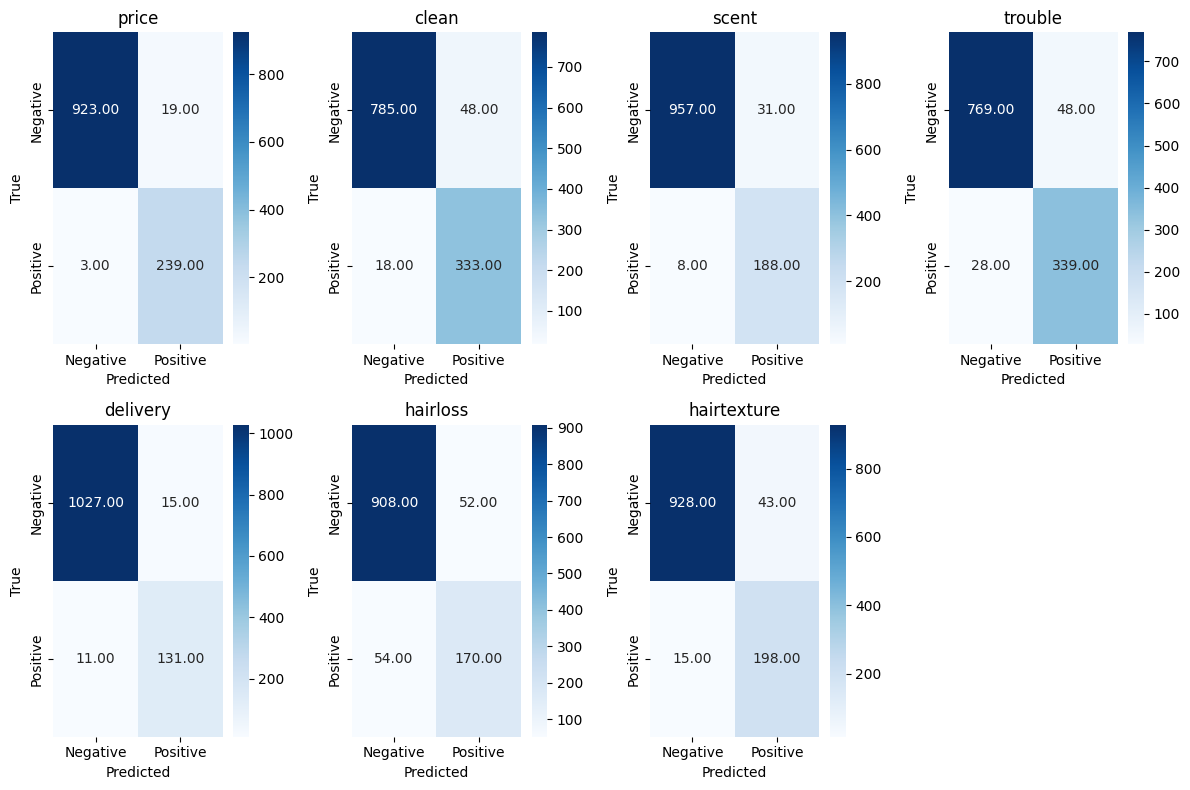

In [45]:
mcm = multilabel_confusion_matrix(test_target, pred)

# Labels for each category
labels = ['price', 'clean', 'scent', 'trouble', 'delivery', 'hairloss', 'hairtexture']

# Confusion matrix visualization
plt.figure(figsize=(12, 8))

for i in range(mcm.shape[0]):
    plt.subplot(2, 4, i + 1)
    sns.heatmap(mcm[i], annot=True, fmt='.2f', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(labels[i])
    plt.xlabel('Predicted')
    plt.ylabel('True')

plt.tight_layout()
plt.show()